In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

sigma = 0.3
def func(x):
    return np.sin(2 * np.pi * x)

def generate_data(N, sigma=0.3, seed=None):
    rng = np.random.default_rng(seed)
    x = rng.uniform(0.0, 1.0, size=N)
    t = func(x) + rng.normal(0.0, sigma, size=N)
    return x, t

In [4]:
# -----------------------------
# Design matrix and fitting
# -----------------------------
def design_matrix(x, M):
    """
    Build design matrix Phi with columns [x^0, x^1, ..., x^M].
    Shape: (N, M+1)
    """
    return np.vander(x, N=M+1, increasing=True)

def fit_poly_ridge(x, t, M, lam=0.0):
    """
    Ridge regression solution:
    w = (Phi^T Phi + lam I)^(-1) Phi^T t
    lam = 0 gives ordinary least squares.
    """
    Phi = design_matrix(x, M)
   
    I = np.eye(M + 1) # Identity matrix
    w = np.linalg.solve(Phi.T @ Phi + lam * I, Phi.T @ t)
    return w

def predict(x, w):
    M = len(w) - 1
    Phi = design_matrix(x, M)
    return Phi @ w

def erms(y, t):
    return np.sqrt(np.mean((y - t) ** 2))

Fit follows the data beter.

### Polynomial Regression Helper Functions

The following block defines several helper functions used for polynomial curve fitting and ridge regression.

---

### **1. `design_matrix(x, M)`**

Constructs the design matrix $\phi$ for polynomial regression.  
For an input vector $x = (x_1, ..., x_N)$ and polynomial degree $M$, the matrix has columns:

$$
\phi = 
\begin{bmatrix}
1 & x_1 & x_1^2 & \dots & x_1^M \\
1 & x_2 & x_2^2 & \dots & x_2^M \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_N & x_N^2 & \dots & x_N^M
\end{bmatrix}
$$

This corresponds to a basis expansion for polynomial regression.  
The resulting shape is $(N, M+1)$.

---

### **2. `fit_poly_ridge(x, t, M, lam)`**

Computes the polynomial regression weights $w$ using ridge regression, whose closed-form solution is:

$$
w = (\phi^T \phi + \lambda I)^{-1} \phi^T t
$$

where:

- $\lambda \ge 0$ is the regularization strength  
- $\lambda = 0$ reduces to ordinary least squares  
- $I$ is the identity matrix ensuring stability for large $M$

Regularization penalizes large coefficient values, helping prevent overfitting for high-degree polynomials.

### Target Values and the Design Matrix

In supervised regression we observe pairs $(x_n, t_n)$, where:

- $x_n$ is the input
- $t_n$ is the **target** or observed output

The model attempts to predict $t_n$ by fitting a function $y(x,w)$. The symbol $t$ is commonly used (e.g. in Bishop’s *Pattern Recognition and Machine Learning*) for the target values that the model tries to match.

---

### Polynomial Basis Expansion

To fit a polynomial of degree $M$, we expand the input $x$ into the basis

$$
[1,\, x,\, x^2,\, \dots,\, x^M].
$$

Instead of manually writing a function such as:

```python
def poly(x): return x + x**2 + x**3 + ...
```

---

### **3. `predict(x, w)`**

Generates model predictions for new inputs $x$.  
Given weights $w$ and design matrix $\phi(x)$:

$$
\hat{y} = \Phi w
$$

---

### **4. `erms(y, t)`**

Computes the root-mean-square error:

$$
E_{\mathrm{RMS}} = \sqrt{\frac{1}{N}\sum_{n=1}^N (y_n - t_n)^2}
$$

This metric is used to evaluate model performance on training or test sets.


In [5]:
# -----------------------------
# 3. Simple visualization: different M, N=10 / 100 / 1000
# -----------------------------

def plot_fits_for_sample_sizes():
    Ns = [10, 100, 1000]
    M_max = 9

    x_plot = np.linspace(0, 1, 1000)
    y_true = func(x_plot)

    for N in Ns:
        x, t = generate_data(N, sigma=sigma, seed=0)

        plt.figure(figsize=(6, 4))
        plt.scatter(x, t, alpha=0.3, c="black", label="data")
        plt.plot(x_plot, y_true, label=r"sin(2 $\pi$ x)")

        for M in [0, 1, 3, 9]:
            w = fit_poly_ridge(x, t, M, lam=0.0)
            y_fit = predict(x_plot, w)
            plt.plot(x_plot, y_fit, label=f"N={M}")

        plt.title(f"Polynomial fits, N={N}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.grid(True)
    plt.show()

In [6]:
def train_test_errors_regularization(log_lam=None):
    """
    If log_lam is None -> no regularization.
    Otherwise lambda = exp(log_lam).
    """
    N = 100
    x_all, t_all = generate_data(N, sigma=sigma, seed=1)

    rng = np.random.default_rng(1)
    idx = rng.permutation(N)
    N_train = int(0.25 * N)
    train_idx = idx[:N_train]
    test_idx = idx[N_train:]

    x_train, t_train = x_all[train_idx], t_all[train_idx]
    x_test, t_test = x_all[test_idx], t_all[test_idx]

    M_max = 9
    Ms = np.arange(0, M_max + 1)
    Erms_train = []
    Erms_test = []

    if log_lam is None:
        lam = 0.0
        label_suffix = "(no regularization)"
    else:
        lam = np.exp(log_lam)
        label_suffix = f"(ln λ = {log_lam})"

    for M in Ms:
        w = fit_poly_ridge(x_train, t_train, M, lam=lam)
        y_train = predict(x_train, w)
        y_test = predict(x_test, w)
        Erms_train.append(erms(y_train, t_train))
        Erms_test.append(erms(y_test, t_test))

    plt.figure(figsize=(6, 4))
    plt.plot(Ms, Erms_train, "o-", label="training")
    plt.plot(Ms, Erms_test, "s-", label="test")
    plt.axhline(sigma, linestyle="--", label=r"noise $\sigma$")
    plt.xlabel("Polynomial degree M")
    plt.ylabel(r"$E_{\mathrm{RMS}}$")
    plt.title(f"$E_{{RMS}}$ vs M {label_suffix}")
    plt.legend()
    plt.grid(True)
    plt.show()

### Function: `train_test_errors_regularization(log_lam=None)`

This function evaluates how polynomial model complexity and regularization affect model performance. It generates data, splits it into training and test sets, fits polynomial models of degree $M = 0, \ldots, 9$, and plots the root-mean-square error on both training and test sets.

---

### **1. Data Generation and Splitting**

- Generates $N = 100$ noisy samples from the true function $y = \sin(2\pi x)$
- Uses a fixed random permutation for reproducibility
- Splits into:
  - **25% training**
  - **75% test**

This allows comparison between fitting performance and generalization.

---

### **2. Regularization Setup**

The function accepts a regularization parameter in logarithmic form:

$$
\lambda = e^{\log \lambda}
$$

- If `log_lam = None`, then $\lambda = 0$, corresponding to standard least-squares.
- Otherwise, ridge regression is used with the given $\lambda$.

---

### **3. Loop Over Polynomial Degree**

For each degree $M = 0, \ldots, 9$:

1. Fit weights $w$ using `fit_poly_ridge`
2. Compute predictions for:
   - training set
   - test set
3. Compute the RMS error:

$$
E_{\mathrm{RMS}} = \sqrt{\frac{1}{N}\sum_{n} (y_n - t_n)^2}
$$

Training error typically decreases monotonically with $M$, whereas test error may increase due to **overfitting**.

---

### **4. Plotting Results**

The function produces a plot of $E_{\mathrm{RMS}}$ vs $M$ with:

- solid markers for training/test curves
- a dashed horizontal line at $\sigma$ (the noise level)

This plot illustrates:

- underfitting at low complexity
- overfitting at high complexity
- regularization effects when $\lambda > 0$


In [7]:
def bayesian_posterior_params(x_train, t_train, M, alpha, beta):
  """
  Returns posterior covariance S and posterior mean m_N (for weights w):
    S^{-1} = alpha I + beta Phi^T Phi
    m_N    = beta S Phi^T t
  """
  Phi = design_matrix(x_train, M)
  I = np.eye(M + 1)

  S_inv = alpha * I + beta * (Phi.T @ Phi)
  S = np.linalg.inv(S_inv)
  mN = beta * (S @ Phi.T @ t_train)

  return S, mN

def bayesian_predictive(x_test, S, mN, M, beta):
  """
  Predictive distribution p(t|x, D) = N(t | m(x), s^2(x))
    m(x)  = phi(x)^T mN
    s^2(x)= beta^{-1} + phi(x)^T S phi(x)
  """
  Phi_test = design_matrix(x_test, M)

  mean = Phi_test @ mN
  var = (1.0 / beta) + np.sum((Phi_test @ S) * Phi_test, axis=1)

  return mean, var

def plot_bayesian_curve_fit(N=10, sigma=0.3, seed=0, M=9, alpha=5e-3, beta=11.1):
  # training data
  x_train, t_train = generate_data(N, sigma=sigma, seed=seed)

  # posterior over weights
  S, mN = bayesian_posterior_params(x_train, t_train, M, alpha, beta)

  # prediction grid
  x_plot = np.linspace(0, 1, 400)
  y_true = func(x_plot)

  # predictive mean/variance
  mean, var = bayesian_predictive(x_plot, S, mN, M, beta)
  std = np.sqrt(var)

  # plot
  plt.figure(figsize=(6,4))
  plt.scatter(x_train, t_train, alpha=0.5, c="black", label="data")
  plt.plot(x_plot, y_true, "C0", lw=2, label=r"$\sin(2\pi x)$")
  plt.plot(x_plot, mean, "C1", lw=2, label="predictive mean")

  plt.fill_between(x_plot, mean - std, mean + std, alpha=0.2, label=r"$\pm 1\sigma$ band")

  plt.title(f"Bayesian curve fitting (M={M}, alpha={alpha}, beta={beta}, N={N})")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.grid(True, alpha=0.3)
  plt.legend()
  plt.show()

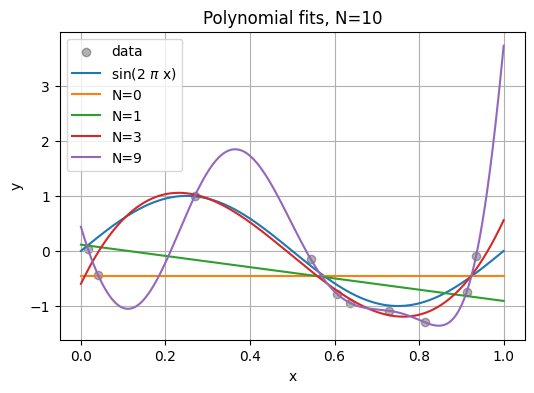

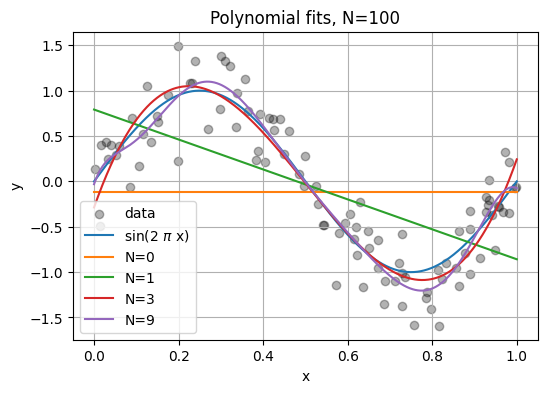

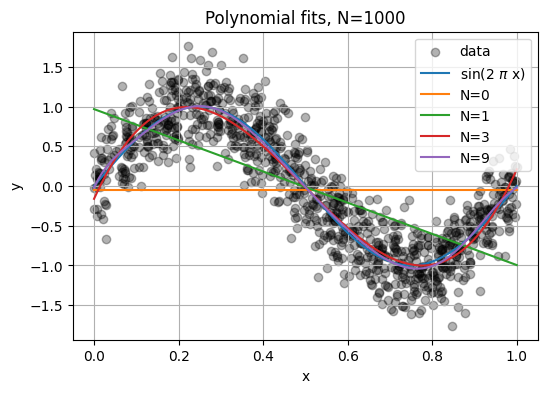

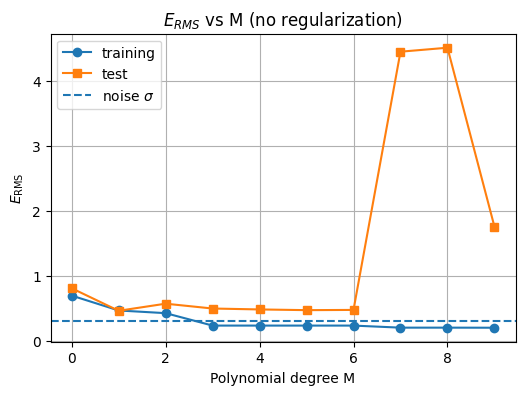

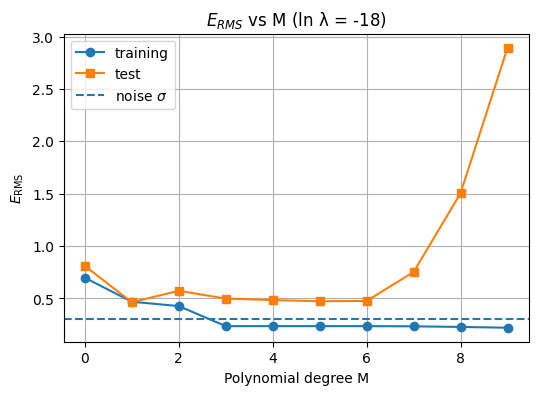

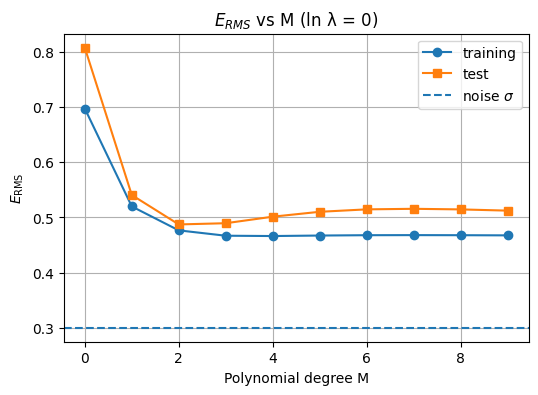

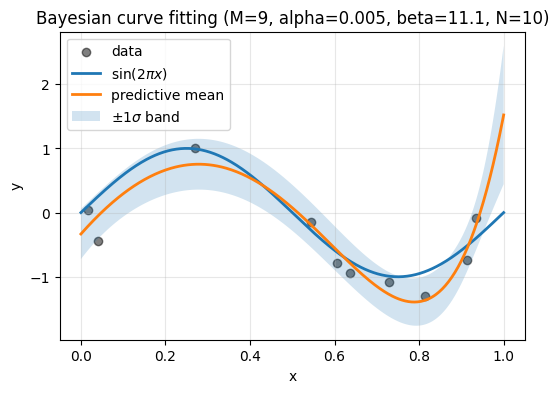

In [8]:
if __name__ == "__main__":
    # Activity 1 style plots
    plot_fits_for_sample_sizes()

    # ERMS vs M without regularization
    train_test_errors_regularization(log_lam=None)

    # Activity 2: regularization
    # ln λ = -18 (very small regularization)
    train_test_errors_regularization(log_lam=-18)

    # ln λ = 0 (λ = 1, stronger regularization)
    train_test_errors_regularization(log_lam=0)

    # Activity 4: Bayesian curve fitting
    plot_bayesian_curve_fit(N=10, sigma=0.3, seed=0, M=9, alpha=5e-3, beta=11.1)

## Problem 3
Find $P(A|B)$

$P(+|A) = 0.98$

$P(+|\text{Not}A) = 0.03$

$P(A) = 0.001$

Bayes Theorem:
$$
P(A|B) = \frac{P(B|A) P(A)}{P(B)} = \frac{0.98 \cdot 0.001}{0.03} = 0.032
$$